<a href="https://colab.research.google.com/github/Wangsherpa/cyclegan_implementation/blob/main/CycleGANS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CycleGANs to generate Ukiyo-e art**

## Introduction

<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/jBk8u1k8fyfY1gL/download" height=400 width=600/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>

The above images are from the paper, **[Unpaired Image-to-Image Translation
using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)** showing cross domain image transfer. This image tranfer method takes an image from an input domain D<sub>i</sub> and then transform it into an image of target domain D<sub>t</sub>. This is achieved by a type of generative model, specifically a Generative Adversarial Network called CycleGAN. 

Image transformation Generative Adversarial Models (GANs) architectures learn from a collection of matched input-output image pairs. But in order to transform an image from one domain to another, say an apple into an orange and vice versa, one would have to build a big stack of images of apples and another stack of oranges. *These sets don't necessarily have a one-to-one mapping between images from input to target domain* which makes it an attractive model to solve varied sets of image translation problems like the one show above where an input image is converted to different artistic styles. 



<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/oSYfmWfthVuXjcY/download" height=400 width=600/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>


GANs  are composed of 2 neural networks: a generator and a discriminator. A CycleGAN is composed of 2 GANs, making it a total of 2 generators and 2 discriminators. CycleGAN is an extension of Pix2Pix architecture which involves simultaneous training of two generator models and two discriminator models with the biggest advantage being that one can use an unpaired dataset and convert images in the reverse direction (target to source imagery) using the same model (as shown in the image above. The image is from the author's paper). The ability of the CycleGAN in learning such transformations without one-to-one mapping between training data in source and target domains makes it powerful as mentioned earlier. The need for a paired image in the target domain is eliminated by making a two-step transformation of source domain image - first by trying to map it to target domain and then back to the original image. 

### Getting Started

In [ ]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, models, activations
from tensorflow.keras.models import Model, Sequential
from tensorflow import pad
from tensorflow.keras.layers import Layer
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization
import time

from IPython.display import clear_output

clear_output()

In [ ]:
# Downloading Data and unizipping it
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip
!unzip ./ukiyoe2photo.zip
!rm ./ukiyoe2photo.zip
clear_output()

# Data
The data we are using is taken from [link](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/ukiyoe2photo.zip). We have two types of images
 1. Ukiyo Art
 2. Reality Images

The goal is to pass reality images through a generator and get ukiyo style output.  

## Taking a first look

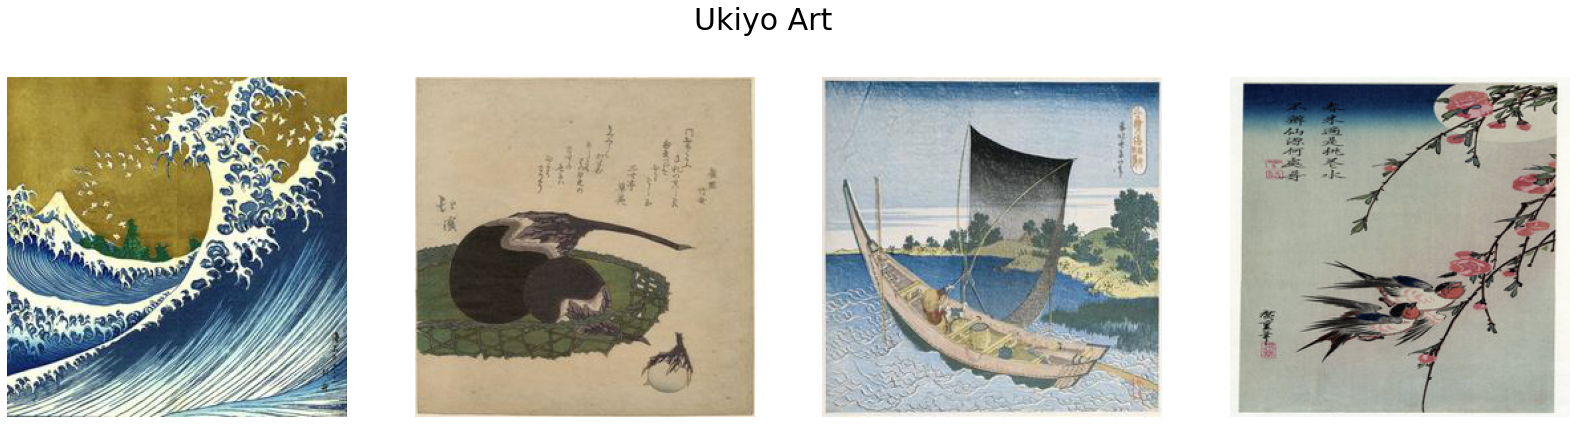

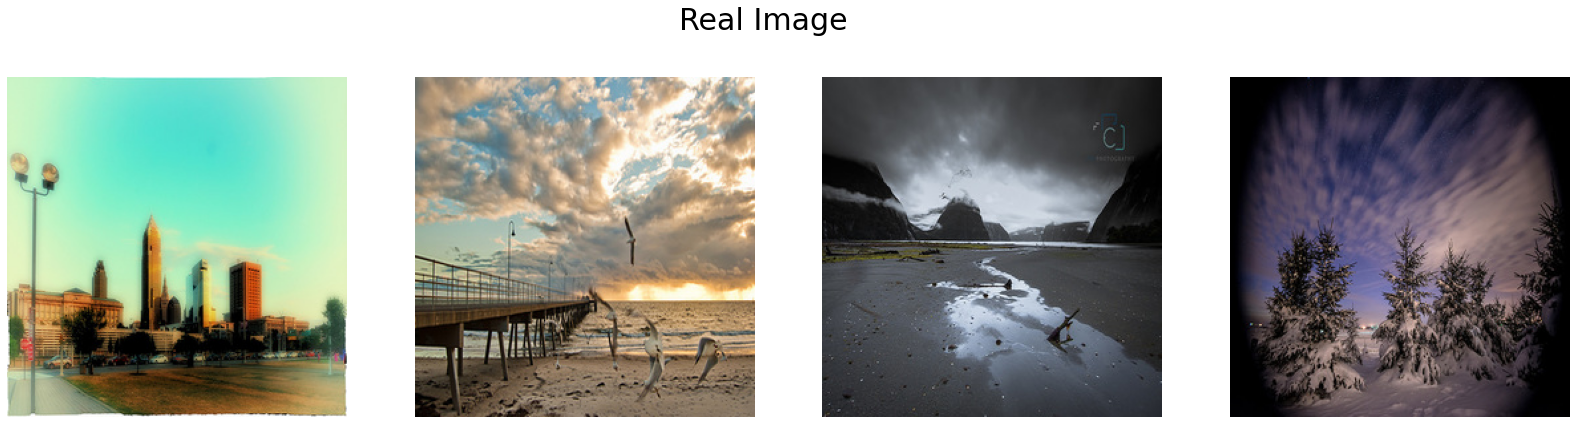

In [ ]:
# Taking a first look at images
PATH = './ukiyoe2photo'
test_paths = [os.path.join(PATH, 'testA'), os.path.join(PATH, 'testB')] 
train_paths = [os.path.join(PATH, 'trainA'), os.path.join(PATH, 'trainB')]

def plot_images(file_path, size=4, title=""):
  fig, ax = plt.subplots(1, size, figsize=(7*size, 7))
  for i, path in enumerate(np.random.choice(os.listdir(file_path), size=size)):
    img = plt.imread(os.path.join(file_path,path))
    ax[i].imshow(img)
    ax[i].axis('off')
  fig.suptitle(title, fontsize=30)

for path, title in zip(train_paths, ['Ukiyo Art', 'Real Image']):
  plot_images(path, title = title)

Paper suggests adding randomness to image to improve output quality.

In [ ]:
# Adding randomness to image

# https://www.tensorflow.org/tutorials/generative/cyclegan#input_pipeline
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[1, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_img(img, train=True):
  img = img.reshape(1,256,256,3)
  if train:
    img = random_jitter(img)
  img = normalize(img)
  return img

def inv_preprocess(img):
  return (img + 1)*127.5

## Data Generator

In [ ]:
# Getting data generator 
def get_datagen(ukiyo_path, reality_path, train=True):
  """
  Create data generator which gives ukiyo and reality image for training.
  Args : 
  ukiyo_path : Path to ukiyo img directory
  reality_path : Path to reality img directory
  train : if true does necessary preprocessing. default = true
  """
  ukiyo_imgs, reality_imgs = os.listdir(ukiyo_path), os.listdir(reality_path)
  if (len(ukiyo_imgs) > len(reality_imgs)):
    reality_imgs.extend(np.random.choice(reality_imgs, len(ukiyo_imgs) - len(reality_imgs)))
  else:
    ukiyo_imgs.extend(np.random.choice(ukiyo_imgs, len(reality_imgs) - len(ukiyo_imgs)))
  assert len(ukiyo_imgs) == len(reality_imgs), f"{len(ukiyo_imgs)} {len(reality_imgs)}"
  

  np.random.shuffle(ukiyo_imgs)
  np.random.shuffle(reality_imgs)
  for ukiyo, reality in zip(ukiyo_imgs, reality_imgs):
    ukiyo_img = plt.imread(os.path.join(ukiyo_path, ukiyo))
    reality_img = plt.imread(os.path.join(reality_path, reality))
    if not (ukiyo_img.shape == reality_img.shape == (256,256,3)):
      continue
    ukiyo_img = preprocess_img(ukiyo_img, train=train)
    reality_img = preprocess_img(reality_img, train=train)
    yield ukiyo_img, reality_img

train_datagen = get_datagen(*train_paths, train=True)
val_datagen = get_datagen(*test_paths, train=False)

# Model Architecture

The CycleGAN has two generators and two discriminators. One generator takes images from the first domain as input and generates images for the second domain, and the second generator takes images from the second domain as input and generates images for the first domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly.

But as the authors note, this alone is not enough to ensure that the translation is exact. There is an additional parameter the checks if the image output from the first generator that is fed as input to the second, results in an output that matches the first generator's input. This is called cycle consistency. The reverse is also true: that an output from the second generator can be fed as input to the first generator and the result should match the input to the second generator.

> … we exploit the property that translation should be “cycle consistent”, in the sense that if we translate, e.g., a sentence from English to French, and then translate it back from French to English, we should arrive back at the original sentence
>
> — <cite>Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, 2017.</cite>

An additional loss term is added to encourage cycle consistency and then to measure the difference between the generated output of the second generator and the original input image, and the reverse. This acts as a regularization of the generator models.




<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/Lg0COnQ1r2jvuL2/download" height=400 width=600/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>

<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/5nVmJrVAAYGQStI/download" height=400 width=600/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>


This first image shows the first half of CycleGAN with the aim to generate a fake horse from a real zebra. The second image shows the second half of the CycleGAN that tries to generate a fake zebra from a real horse. Both halves include cycle consistency loss which makes the inverted generator's output match the input of the non inverted generator. A patch based Discriminator is used for both of the directional GANs. The classification matrix output (as opposed to a single number as output) from the Discriminator is associated with the individual positions of the Patch as it is positioned across the image.  

## Generator Architecture

The generator have three components:

    Encoder
    Transformer
    Decoder


Generators take as input image of size 256x256, down sample them, then up sample them back to 256x256 creating the generated image.



<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/Wa8wFqE7GoNhzt0/download" height=200 width=1000/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>

<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/DAR9SyCsE7L3Vl4/download" height=200 width=600/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>


Images from: https://hardikbansal.github.io/CycleGANBlog/ and https://towardsdatascience.com/overview-of-cyclegan-architecture-and-training-afee31612a2f 

### Building Generator

In [ ]:
# Paper suggests using reflection padding to reduce artifacts in images
# from https://www.machinecurve.com/index.php/2020/02/10/using-constant-padding-reflection-padding-and-replication-padding-with-keras/
'''
  2D Reflection Padding
  Attributes:
    - padding: (padding_width, padding_height) tuple
'''
# Used to reduce artifacts
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'REFLECT')
        

In [ ]:
# Building Blocks for generator
# used for downscaling and as a building block for residual layer
class ConvBlock(Layer):
  def __init__(self, n_filters, filter_size, strides=1, use_dropout=False, padding=(0,0), use_activation=True, **kwargs):
    super().__init__()
    self.model = Sequential([
        layers.Conv2D(n_filters, filter_size, strides=strides, **kwargs),
        ReflectionPadding2D(padding=padding),
        #layers.BatchNormalization()
        InstanceNormalization()
    ])
    if use_dropout:
      self.model.add(layers.Dropout(.5))
    if use_activation:
      self.model.add(layers.Activation(activations.relu))
  def call(self, inputs):
    return self.model(inputs)

# Used for upscaling
class TransposeConvBlock(Layer):
  def __init__(self, n_filters, filter_size, strides=1, use_dropout=False, use_activation=True, **kwargs):
    super().__init__()
    self.model = Sequential([
        layers.Conv2DTranspose(n_filters, filter_size, strides=strides, **kwargs),
        InstanceNormalization()
        #layers.BatchNormalization()
    ])
    if use_dropout:
      self.model.add(layers.Dropout(.5))
    if use_activation:
      self.model.add(layers.Activation(activations.relu))
  def call(self, inputs):
    return self.model(inputs)

# For residual layer
class ResidualBlock(Layer):
  def __init__(self, n_filters):  
    super().__init__()
    self.model = Sequential([
        ConvBlock(n_filters, 3, padding=(1,1)),
        ConvBlock(n_filters, 3, use_activation=False, padding=(1,1))
    ])

  def call(self, inputs):
    return inputs + self.model(inputs)

In [ ]:
# Creating generator class
# We'll use this to create two generators one for ukiyo images and
# the other for reality images
class Generator(Layer):
  def __init__(self, n_filters=32, num_residuals=9):
    super().__init__()
    self.initial = Sequential([
                               ConvBlock(n_filters, 7, 1),
                               ConvBlock(2*n_filters, 3, 2, use_dropout=True, padding=(1,1)),
                               ConvBlock(4*n_filters, 3, 2, use_dropout=True, padding=(1,1))
    ])
    self.res_blocks = Sequential([
                                   ResidualBlock(4*n_filters) 
                                   for _ in range(num_residuals)
                                   ])
    self.upsample = Sequential([
                                TransposeConvBlock(2*n_filters, 3, 2, use_dropout=True),
                                TransposeConvBlock(1*n_filters, 3, 2, use_dropout=True, output_padding=1)
    ])

    self.last = ConvBlock(3, 7, 1, padding=(1,1), use_activation=False)

  def call(self, x):
    x = self.initial(x)
    x = self.res_blocks(x)
    x = self.upsample(x)
    x = self.last(x)
    return activations.tanh(x)


In [ ]:
# Testing generator output shape
# We expect output to the same shape as input
img_channels = 3
img_size = 256
x = np.random.random(size=(2, img_size, img_size, img_channels))
gen = Generator(32)
print(gen(x).shape)

(2, 256, 256, 3)


## Discriminator Architecture

<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/Jwrmymm9jtrFEJI/download" height=200 width=1000/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>

PatchGANs are used in the discriminator models to classify 70×70 overlapping patches of input images as belonging to the domain or having been generated. The discriminator output is then taken as the average of the prediction for each patch. "The benefit of this approach is that the same model can be applied to input images of different sizes, e.g. larger or smaller than 256×256 pixels."

The output of the model depends on the size of the input image but may be one value or a square activation map of values. Each value is a probability for the likelihood that a patch in the input image is real. These values can be averaged to give an overall likelihood or classification score if needed.

Additionally, a buffer of 50 generated images is used to update the discriminator models instead of freshly generated images, as described in Ashish Shrivastava’s 2016 paper titled “[Learning from Simulated and Unsupervised Images through Adversarial Training.](https://arxiv.org/abs/1612.07828)”. This reduces mode oscillation. 

The above image is taken from: https://hardikbansal.github.io/CycleGANBlog/

### Building Discriminator

In [ ]:
# Building block for discriminator
class Block(Layer):
  def __init__(self, n_filters, use_batchnorm=True, strides=2):
    super().__init__()
    self.model = Sequential([
                             layers.Conv2D(n_filters, 4, strides),
                             ReflectionPadding2D((1,1))
    ])
    if use_batchnorm:
      #self.model.add(layers.BatchNormalization())
      self.model.add(InstanceNormalization())
    self.model.add(layers.LeakyReLU(.2))

  def call(self, x):
    return self.model(x)

In [ ]:
# Final disciminator class
# this class is used to create discriminators for ukiyo and reality images
class Discriminator(Layer):
  def __init__(self):
    super().__init__()
    filters = [64,128,256,512]
    self.model = Sequential([
                             Block(filters[0], False)
    ])
    for n_filters in filters[1:]:
      self.model.add(Block(n_filters, strides=2 if n_filters!=filters[-1] else 1))
    self.model.add(Block(1, False, 1))
    self.model.add(layers.Activation(activations.sigmoid))

  def call(self, x):
    return self.model(x)

In [ ]:
# Our discriminator is a PatchGAN, from Pix2Pix paper
# It doesn't output a single value instead a grid of probabilities for images being real
# A/c to paper each cell looks at a 70x70 region
img_channels = 3
img_size = 256
x = np.random.random(size=(2, img_size, img_size, img_channels))
dis = Discriminator()
print(dis(x).shape)

(2, 31, 31, 1)


# Loss Functions

CycleGANs have a training objective function, which is to be minimized. The loss function is to be designed in such a  way that both generators and both discriminators are kept accountable. In other words:

1. The Discriminator must rightly recognise all the original images of the corresponding categories.
2. Discriminator must reject all the images which are generated by corresponding Generators to fool them.
3. Generators must fool the discriminators for all the generated images.
4. The generated image must retain the property of original image ie it must satisfy cyclic-consistency.

The above 3 can be clubbed together into what we call an 'adversarial loss' and the last condiition is taken care of by 'cyclical consistency loss'.

The loss function is a weighted sum of the losses. The image below from the paper shows the schematic of the mappings and loss functions.



<figure>
<center>
<img src= "https://uni-koeln.sciebo.de/s/e1valR2veddx2jI/download" height=300 width=800/>
<figcaption><b>CycleGAN</b></figcaption></center>
</figure>

## Adversarial Loss

$\mathcal{L}_{\mathrm{GAN}}(\mathrm{G, D_{x}, X, Y}) = \mathbb{E}_{y \sim p(y)}[\mathrm{log D_{y}}(y)] + \mathbb{E}_{x \sim p(x)}[\mathrm{1 - log D_{y}}(\mathrm{G}(x))] $

where, x is an image from the distribution of domain A, and y is an image from the distribution of domain B. Discriminator D(y) computes the difference between the generated image by the Generator G and its mapping G(X), and the real image y from a different distribution of domain B.
The Discriminator D(X) finds the difference between the generated image by the second generator and its mapping F(y) and the real image x from the distribution of domain A.
The objective of G is to minimize the adversarial loss function against a Discriminator D, which constantly tries to maximize it.

## Cycle Consistency Loss

$\mathcal{L}_{cyc}(G, F) = \mathbb{E}_{x \sim p_{data}(x)}[\parallel F(G(x)) - x\parallel_1] + \mathbb{E}_{y \sim p_{data}(y)}[\parallel G(F(y)) - y\parallel_1] $

Each of the GANs are also updated using cycle consistency loss.

Cycle consistency loss compares an input photo to the generated photo and calculates the difference between the two using the L1 norm or summed absolute difference in pixel values.

The first GAN (GAN 1) will take an image of a horse, generate image of a zebra, which is provided as input to the second GAN (GAN 2), which in turn will generate an image of a horse. The cycle consistency loss calculates the difference between the image input to GAN 1 and the image output by GAN 2 and the generator models are updated accordingly to reduce the difference in the images.

This is called *forward-cycle for cycle consistency loss* and can be seen in the figure above. Similarly, the process is repeated in the reverse order for a *backward cycle consistency loss* from generator 2 to generator 1 and comparing the original photo of a zebra to the generated photo of a horse.

Forward Cycle Consistency Loss: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B \\
Backward Cycle Consistency Loss: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A




## Identity Loss

For transformations involving painting to photo, an additional loss function is required. 

$\mathcal{L}_{identity}(G, F) = \mathbb{E}_{x \sim p_{data}(x)}[\parallel F(x) - x\parallel_1] + \mathbb{E}_{y \sim p_{data}(y)}[\parallel G(y) - y\parallel_1] $

The identity loss encourages the generator to preserve the color composition between input and output. This is done by providing the generator an image of its target domain as an input and calculating the L1 loss between input and the generated images.

Without the identity loss, the generator G and F are free to change the tint of input images when there is no need to.

As all of these loss functions play critical roles in arriving at high-quality results. Hence, both the generator models are optimized via combination of all of these loss functions. The loss of discriminators is halved. Doing so is equivalent to use adversarial loss to update discriminator weights once every time it updates generator weights twice.
The cycle consistency loss has a larger weightage (=10) than the adversarial loss in the total loss function.

# Training Model

Generators and discriminators are all optimized with an Adam solver, they all have the same learning rate (2e-4) for 100 epochs and then a further 100 epochs with a learning rate decay. The batch size is chosen to be 1 ie instance normalization is used. 



In [ ]:
# Getting generators
ukiyo_gen = Generator()
reality_gen = Generator()

# Getting discriminators
ukiyo_dis = Discriminator()
reality_dis = Discriminator()

In [ ]:
# Optimizers to learn from loss
# We use adam for both generators and discriminators

# Discriminator optimizer
opt_dis = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.999)
# Generator optimizer
opt_gen = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5, beta_2=0.999)

# Losses 

# L1 used for
#   cyclic loss while training generator
#   identity loss while training generator
L1 = keras.losses.MeanAbsoluteError()

# MSE used for
#   discriminator loss function
#   adverserial loss while training generator
mse = keras.losses.MeanSquaredError()

In [ ]:
# Setting hyperparameters
EPOCHS = 5 # Paper suggests going for 200 epochs
LAMBDA_IDENTITY = 5
LAMBDA_CYCLE = 10


total_train_steps = max(len(os.listdir(train_paths[1])), len(os.listdir(train_paths[0])))

In [ ]:
# Training Loop

tic = time.time()
for epoch in range(EPOCHS):
  train_datagen = get_datagen(*train_paths, train=True)
  for step, (ukiyo_img, reality_img) in enumerate(train_datagen):
    print(f"Epoch #{epoch+1} // {EPOCHS}")
    print(f"  {step+1} // {total_train_steps}")
    # Train Discriminator
    with tf.GradientTape() as tape:
      fake_ukiyo = ukiyo_gen(reality_img)
      D_ukiyo_real = ukiyo_dis(ukiyo_img)
      D_ukiyo_fake = ukiyo_dis(fake_ukiyo)
      D_ukiyo_real_loss = mse(D_ukiyo_real, tf.ones_like(D_ukiyo_real))
      D_ukiyo_fake_loss = mse(D_ukiyo_fake, tf.zeros_like(D_ukiyo_fake))
      D_ukiyo_loss = D_ukiyo_real_loss + D_ukiyo_fake_loss

      fake_reality = reality_gen(ukiyo_img)
      D_reality_real = reality_dis(reality_img)
      D_reality_fake = reality_dis(fake_reality)
      D_reality_real_loss = mse(D_reality_real, tf.ones_like(D_reality_real))
      D_reality_fake_loss = mse(D_reality_fake, tf.zeros_like(D_reality_fake))
      D_reality_loss = D_reality_real_loss + D_reality_fake_loss

      # Paper suggests multiplying discrimator loss by 1/2 to reduce rate of training of discriminator
      D_loss = .5 * (D_ukiyo_loss + D_reality_loss)
    grads = tape.gradient(D_loss, [ukiyo_dis.trainable_weights, reality_dis.trainable_weights])
    opt_dis.apply_gradients(zip(grads[0], ukiyo_dis.trainable_weights))
    opt_dis.apply_gradients(zip(grads[1], reality_dis.trainable_weights))
    
    # Train Generator
    with tf.GradientTape() as tape:
      # Adverserial Loss
      D_ukiyo_fake = ukiyo_dis(fake_ukiyo)
      D_reality_fake = reality_dis(fake_reality)
      ukiyo_gen_loss = mse(D_ukiyo_fake, tf.ones_like(D_ukiyo_fake))
      reality_gen_loss = mse(D_reality_fake, tf.ones_like(D_reality_fake))
      adverserial_loss = ukiyo_gen_loss + reality_gen_loss

      #Cyclic Loss
      cycle_ukiyo = ukiyo_gen(fake_reality)
      cycle_reality = reality_gen(fake_ukiyo)
      ukiyo_cycle_loss = L1(ukiyo_img, cycle_ukiyo)
      reality_cycle_loss = L1(reality_img, cycle_reality)
      cyclic_loss = ukiyo_cycle_loss + reality_cycle_loss

      # Identity Loss
      ukiyo_identity = ukiyo_gen(ukiyo_img)
      reality_identity = reality_gen(reality_img)
      ukiyo_identity_loss = L1(ukiyo_img, ukiyo_identity)
      reality_identity_loss = L1(reality_img, reality_identity)
      identity_loss = ukiyo_identity_loss, reality_identity_loss
        
      G_loss = adverserial_loss + LAMBDA_CYCLE * cyclic_loss + LAMBDA_IDENTITY * identity_loss
    grads = tape.gradient(G_loss, [ukiyo_gen.trainable_weights, reality_gen.trainable_weights])
    opt_gen.apply_gradients(zip(grads[0], ukiyo_gen.trainable_weights))
    opt_gen.apply_gradients(zip(grads[1], reality_gen.trainable_weights))
    clear_output()
toc = time.time()
print(f"Time Taken {int((toc-tic)/60)} mins")

# Results

In [ ]:
# Helper function to visualize results
def show_output(img_lst=[], size=2, to_ukiyo=True, from_ukiyo=False):
  """
  Function to show outputs from validation data
  img_lst : specify list of image names to display them. If empty choose randomly
            of specified size. default = []
  size : if img_lst is empty randomly choose "size" images to plot. default = 2
  to_ukiyo : uses ukiyo generator if true else reality generator. default = true
  from_ukiyo : uses ukiyo images as input if true else reality images. default = false
  """
  path = test_paths[0 if from_ukiyo else 1]
  if len(img_lst)==0:
    lst = os.listdir(path)
    img_lst = np.random.choice(lst, size)
  
  fig, ax = plt.subplots(len(img_lst), 2, figsize=(10, 5*len(img_lst)))
  for i, img in enumerate(img_lst):
    original_arr = plt.imread(os.path.join(path, img))
    arr = preprocess_img(original_arr.copy(), train=False)
    if to_ukiyo:
      arr = ukiyo_gen(arr)[0]
    else:
      arr = reality_gen(arr)[0]
    arr = inv_preprocess(arr)
    ax[i][0].imshow(original_arr)
    ax[i][0].set_title("Input")
    ax[i][0].axis('off')
    ax[i][1].imshow(arr.numpy().astype(int))
    ax[i][1].set_title("Output")
    ax[i][1].axis('off')

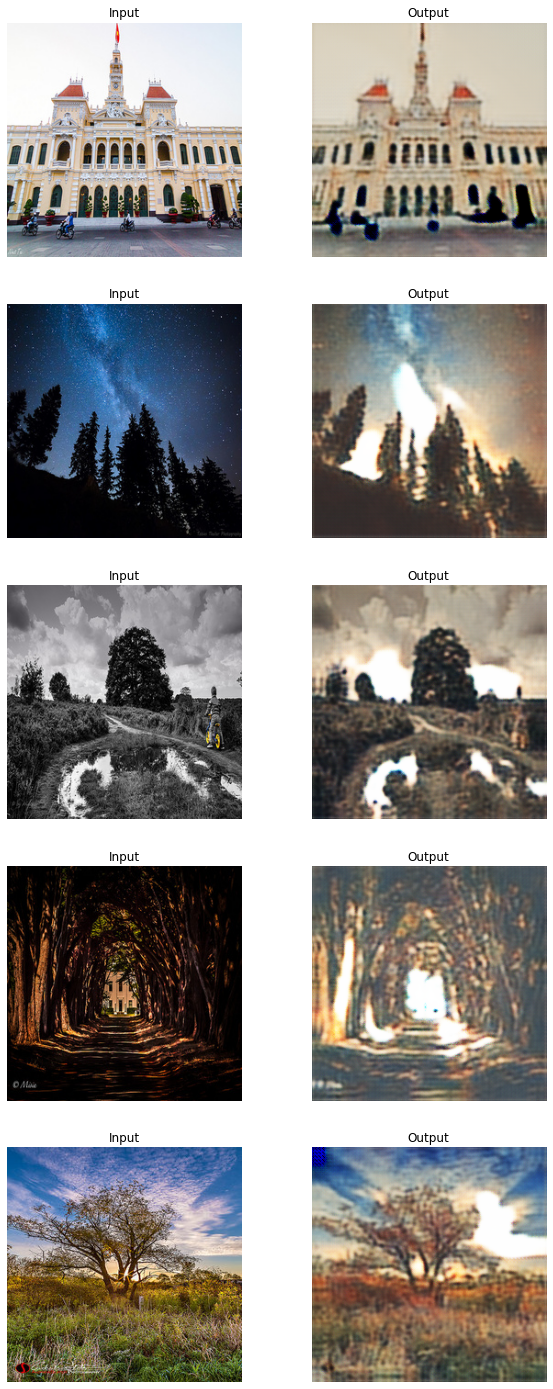

In [ ]:
#@title
show_output(size=5)

# U-Net Architecture

<figure>
<center>
<img src='https://drive.google.com/uc?id=1zB5Pj1yqi9hXPFpxkVDCQzAbT_wXA3bE' width=400 height=300/>
<figcaption><b>Generator Architecture</b></figcaption></center>

<center>
<img src='https://drive.google.com/uc?id=1DPLzJowQWy7BvIRTrfkwqmzRCLaak1Pl'
height=400/>
<figcaption><b>UNet Architecture</b></figcaption></center>
</figure>

We replaced the generator architecure with U-Net

If we closely look at the above architectures of the two models, their structure is kind of similar. Both have Encoder, Transformation ( Bottleneck in case of UNet) and Decoder blocks. Both takes an image as an input and also outputs an image. So, we wanted to see how the model would perform if we replace the Generators architecture with the UNet's architecture. Only the generator architecture is different and everything else is same, i.e, no changes in the discriminators, the loss functions and the training steps.

You can find the notebook used to train this model [here](https://colab.research.google.com/drive/1pmWqeTuQIjP14iD1obFFBE0-VhJCimuc)

Below are the results after training the model for 30 epochs.

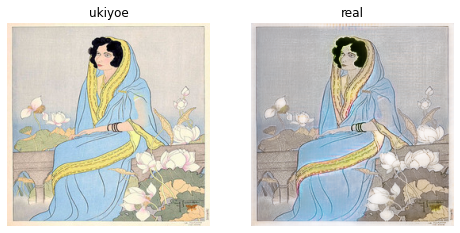

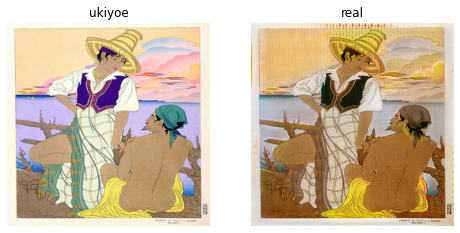

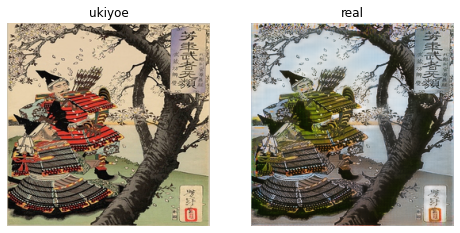

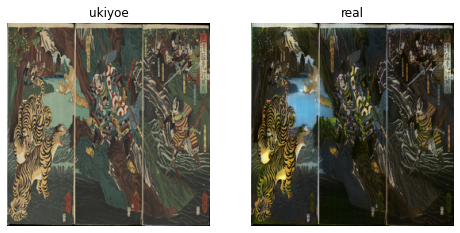

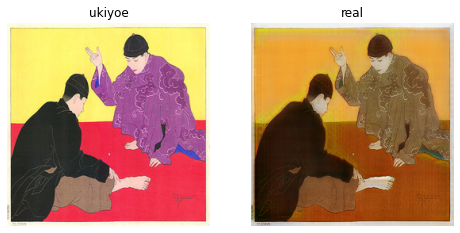

In [ ]:
# Ukiyoe Art to Real Image

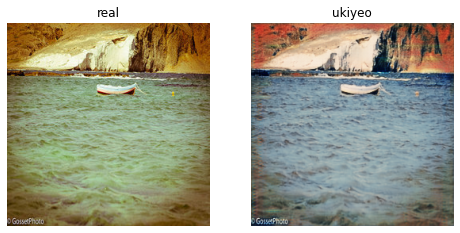

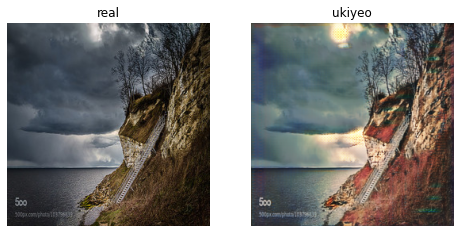

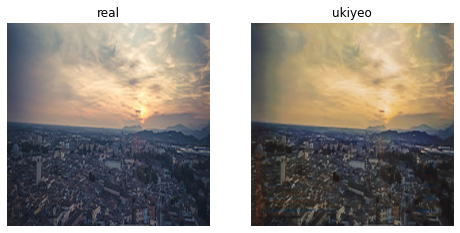

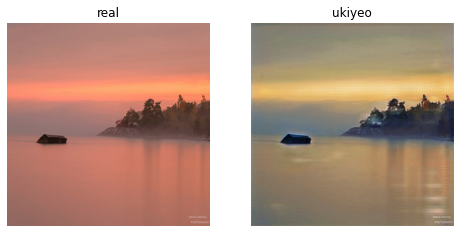

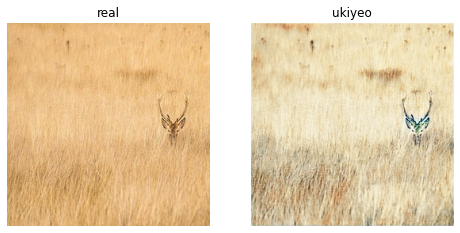

In [ ]:
# Real Image to Ukiyoe Art

# Other Applications

CycleGAN has been used for a varied set of image to image tranformation problems such as:

* Converting satellite image to map.
* Body image to avatar.
* Colorization of grayscale images.
* Conversion of low quality images to appear highly resolved.
* Conversion of photos to artisitc style images.
* Convert ancient hand-drawn city maps (Jerusalem, Babylon, London) into modern satellite views.
* Converting medican scans such as MRI and CT to photos.

# Concluding Remarks and Learning Highlights

Here, we learnt how to develop a model that can learn how to translate the style of one set of images to the style of another, in the absence of paired training examples.

CycleGANs "exploit the property that translation should be “cycle consistent”, in the sense that if we translate, e.g., a sentence from English to French, and then translate it back from French to English, we should arrive back at the original sentence." 

The biggest advantage of CycleGANS is that the method does not rely on any "task-specific pre-defined similarity function between the input and output", and neither does it assume that the input and output have to lie in the same low-dimensional embedding space. Instead the model learns the mapping between two domains by trying to capture relationships between higher-level features. This is why it can be applied to problems such as paintings to photos transformations.

But the method is not without issues. As the authors note, the results obtained from CycleGANs are far from uniform. Tasks that involve geometric changes result in translations don't perform well enough. And a gap between the results that are achievable with paired training data and those achieved by unpaired data using CycleGAN eixts. 

An interesting [research work](https://arxiv.org/pdf/1805.08841.pdf) showed that given how the models work through matching the translation output to the distribution of the target domain, there can be problems is the data provided in the target domain if it has an over or under representation of some classes (e.g. healthy or sick). This can lead to what they call "hallucinated image features", such as tumors,  which should not be used for direct interpretation (e.g. by doctors). 

We trained our model to generate Ukiyo style images successfully. But given the computational limits, our results cannot be compared with that of the author. We can benefit from a longer epoch training than what we use. Nonetheless, CycleGANs don't fail to impress.
Another point worth remembering is that the replication of results is not nearly possible unless averaged over very long training periods due to the stochastic nature of the model and training process.  


If we compare the results of our two models, the model with UNet generators is performing better given that it has been trained longer (for 30 epochs). Not only the results look better but also the training process was also faster.

We believe that CycleGANs and GANs in general have a much greater utility especially in the fields of medical science and remote sensing. 


# Bibliography

* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* https://github.com/junyanz/CycleGAN
* [Understanding and Implementing CycleGAN in TensorFlow](https://hardikbansal.github.io/CycleGANBlog/)
* [A Gentle Introduction to CycleGAN for Image Translation](https://machinelearningmastery.com/what-is-cyclegan/)
* [CycleGAN in PyTorch](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/CycleGAN)
* [Distribution Matching Losses Can Hallucinate
Features in Medical Image Translation](https://arxiv.org/pdf/1805.08841.pdf)
* [Unet Architecture](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)


